# 준비 사항

In [2]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

# 데이터 로드

In [5]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git 

Cloning into 'nsmc'...
Updating files:   6% (1015/14737)
Updating files:   7% (1032/14737)
Updating files:   8% (1179/14737)
Updating files:   9% (1327/14737)
Updating files:  10% (1474/14737)
Updating files:  11% (1622/14737)
Updating files:  12% (1769/14737)
Updating files:  13% (1916/14737)
Updating files:  14% (2064/14737)
Updating files:  15% (2211/14737)
Updating files:  15% (2349/14737)
Updating files:  16% (2358/14737)
Updating files:  17% (2506/14737)
Updating files:  18% (2653/14737)
Updating files:  19% (2801/14737)
Updating files:  20% (2948/14737)
Updating files:  21% (3095/14737)
Updating files:  22% (3243/14737)
Updating files:  23% (3390/14737)
Updating files:  23% (3408/14737)
Updating files:  24% (3537/14737)
Updating files:  25% (3685/14737)
Updating files:  26% (3832/14737)
Updating files:  27% (3979/14737)
Updating files:  28% (4127/14737)
Updating files:  29% (4274/14737)
Updating files:  30% (4422/14737)
Updating files:  30% (4452/14737)
Updating files:  31% (456

In [2]:
# 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [3]:
total = pd.read_csv('total_data.csv')

In [4]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(total, test_size = 0.2, random_state = 42)

In [5]:
# 훈련셋의 앞부분 출력
train.head(10)

,label,rating,review
175253,0,6,캐러멜 매력 적 후식 제품 형태 유지 관심 나 조금 안 맞다 하나 부록 줄 알다 퓌...
147126,1,10,연말 연 시 정말 강력 추천
54857,1,10,책 특정 요리 어떻다 만들다 맛 식 레시피 보여주다 책 아니다 오히려 요리 대한 근...
185454,1,10,일러스트 카드 3 개 중 리야 카드 1 개 안 오다 누락 같다 받다 방법 없다
142666,1,10,번역 체 인하다 간혹 호흡 길어지다 문장 많다 그렇다 중요하다 내용
288022,1,5,종교 종교 철학 이면 철학
373906,0,5,권하다 쉬다 않다
352322,0,5,나름 기대하다 영 아니다
177191,0,6,다른 국가 주택 정책 살펴보다 마지막 우리나라 상황 점검 기회 제공 사진 통해 이해...
336618,0,5,뭐 이영화 질 포르노 수준


# 전처리 - 훈련셋

In [6]:
# 리뷰 문장 추출
sentences = train['review']
sentences[:10]

175253    캐러멜 매력 적 후식 제품 형태 유지 관심 나 조금 안 맞다 하나 부록 줄 알다 퓌...
147126                                      연말 연 시 정말 강력 추천
54857     책 특정 요리 어떻다 만들다 맛 식 레시피 보여주다 책 아니다 오히려 요리 대한 근...
185454          일러스트 카드 3 개 중 리야 카드 1 개 안 오다 누락 같다 받다 방법 없다
142666                번역 체 인하다 간혹 호흡 길어지다 문장 많다 그렇다 중요하다 내용
288022                                       종교 종교 철학 이면 철학
373906                                            권하다 쉬다 않다
352322                                        나름 기대하다 영 아니다
177191    다른 국가 주택 정책 살펴보다 마지막 우리나라 상황 점검 기회 제공 사진 통해 이해...
336618                                       뭐 이영화 질 포르노 수준
Name: review, dtype: object

In [7]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 캐러멜 매력 적 후식 제품 형태 유지 관심 나 조금 안 맞다 하나 부록 줄 알다 퓌레 첨가 물들다 만들다 방법 시판 용 대체 되어다 없다 많이 아쉽다 캐러멜화 이론 적 부분 많다 도움 되어다 [SEP]',
 '[CLS] 연말 연 시 정말 강력 추천 [SEP]',
 '[CLS] 책 특정 요리 어떻다 만들다 맛 식 레시피 보여주다 책 아니다 오히려 요리 대한 근본 적 이면 쉬다 알 없다 중요하다 의문 알 갈다 책 [SEP]',
 '[CLS] 일러스트 카드 3 개 중 리야 카드 1 개 안 오다 누락 같다 받다 방법 없다 [SEP]',
 '[CLS] 번역 체 인하다 간혹 호흡 길어지다 문장 많다 그렇다 중요하다 내용 [SEP]',
 '[CLS] 종교 종교 철학 이면 철학 [SEP]',
 '[CLS] 권하다 쉬다 않다 [SEP]',
 '[CLS] 나름 기대하다 영 아니다 [SEP]',
 '[CLS] 다른 국가 주택 정책 살펴보다 마지막 우리나라 상황 점검 기회 제공 사진 통해 이해 도움 단 주택 미래 예측 어렵다 건 당연하다 일 ㅠ [SEP]',
 '[CLS] 뭐 이영화 질 포르노 수준 [SEP]']

In [8]:
# 라벨 추출
labels = train['label'].values
labels

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [9]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 캐러멜 매력 적 후식 제품 형태 유지 관심 나 조금 안 맞다 하나 부록 줄 알다 퓌레 첨가 물들다 만들다 방법 시판 용 대체 되어다 없다 많이 아쉽다 캐러멜화 이론 적 부분 많다 도움 되어다 [SEP]
['[CLS]', '캐', '##러', '##멜', '매', '##력', '적', '후', '##식', '제', '##품', '형', '##태', '유', '##지', '관', '##심', '나', '조', '##금', '안', '맞', '##다', '하', '##나', '부', '##록', '줄', '알', '##다', '[UNK]', '첨', '##가', '물', '##들', '##다', '만', '##들', '##다', '방', '##법', '시', '##판', '용', '대', '##체', '되어', '##다', '없다', '많이', '아', '##쉽', '##다', '캐', '##러', '##멜', '##화', '이', '##론', '적', '부', '##분', '많다', '도', '##움', '되어', '##다', '[SEP]']


리뷰의 최대 길이 : 220
리뷰의 평균 길이 : 27.60017057284553


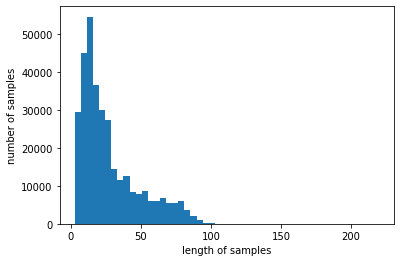

In [13]:
import matplotlib.pyplot as plt


print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_texts))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_texts))/len(tokenized_texts))
plt.hist([len(s) for s in tokenized_texts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
def below_threshold_len(X_train, max_len):
    cnt = 0
    for sent in X_train:
        if(len(sent) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(X_train))*100))

In [18]:
max_len = 128
below_threshold_len(tokenized_texts, max_len=max_len)

전체 샘플 중 길이가 128 이하인 샘플의 비율: 99.95234886699568


In [19]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   9792,  30873, 118930,   9258,  28143,   9664,  10003,
        21155,   9672,  52951,   9983,  83616,   9625,  12508,   8900,
        71013,   8982,   9678,  40032,   9521,   9256,  11903,   9952,
        16439,   9365,  31398,   9692,   9524,  11903,    100,   9748,
        11287,   9299,  27023,  11903,   9248,  27023,  11903,   9328,
        33768,   9485,  33323,   9603,   9069,  29683,  37909,  11903,
        39218,  47058,   9519, 119072,  11903,   9792,  30873, 118930,
        18227,   9638,  42769,   9664,   9365,  37712, 100313,   9087,
       119169,  37909,  11903,    102,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [20]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)				

print(train_inputs[0])
print(train_labels[0])
print(train_masks[0])
print(validation_inputs[0])
print(validation_labels[0])
print(validation_masks[0])

tensor([   101,   9317,   9524,  42144,    100, 106154,   9706,  35866,  32679,
          9681,  12692,  11903,   9706,  31720,    100,   9246,  10622,   9405,
         61250,   9251,   9680,  16439,   9634,    100,   9321,   9665,  42428,
          9551,  11903,   9690,    100,   9666,  14423,   9356,  12508,   9251,
         11903,   9379, 119274,  11903,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [22]:
# 배치 사이즈
batch_size = 16

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 전처리 - 테스트셋

In [23]:
# 리뷰 문장 추출
sentences = test['review']
sentences[:10]

343388           감동 없다 재미 없다 엊그제 영화 노트북 보다 영화 저하 되어다 보이다 끄다
224465                                      생각 한번 더 영화 네 좋다
179224                                           책 살다 사람 호구
241302                                 최고 말 필요없다 진짜 작가 천 재임
97700     학창시절 분 강의 들다 당시 꽃 시가 제자 작품 도용 설 돌다 부인과 해명 강의실 ...
240114                                 보고 또 보다 스릴 잇다 ㅋ 잼 잇다
133201                                                  NaN
98898                               경제 적 해자 워런 버핏 투자 기법 알 책
389379    몸 파다 좋다 집 살다 가정부 쓰다 여자 성의 노리개 온 국민 분노하다 포인트 말 ...
73172                              참신하다 다시 성악설 어떻다 논리 일지 기대
Name: review, dtype: object

In [24]:
# BERT의 입력 형식에 맞게 변환
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 감동 없다 재미 없다 엊그제 영화 노트북 보다 영화 저하 되어다 보이다 끄다 [SEP]',
 '[CLS] 생각 한번 더 영화 네 좋다 [SEP]',
 '[CLS] 책 살다 사람 호구 [SEP]',
 '[CLS] 최고 말 필요없다 진짜 작가 천 재임 [SEP]',
 '[CLS] 학창시절 분 강의 들다 당시 꽃 시가 제자 작품 도용 설 돌다 부인과 해명 강의실 분위기 묘 적 후 어떻다 진실 밝혀지다 모르다 시인 국회의원 나가다 폼 잡다 행보 상해 난 분 그렇다 [SEP]',
 '[CLS] 보고 또 보다 스릴 잇다 ㅋ 잼 잇다 [SEP]',
 '[CLS] nan [SEP]',
 '[CLS] 경제 적 해자 워런 버핏 투자 기법 알 책 [SEP]',
 '[CLS] 몸 파다 좋다 집 살다 가정부 쓰다 여자 성의 노리개 온 국민 분노하다 포인트 말 안되다 주제 오광록 씨 국어 책 읽다 연기 [SEP]',
 '[CLS] 참신하다 다시 성악설 어떻다 논리 일지 기대 [SEP]']

In [25]:
# 라벨 추출
labels = test['label'].values
labels

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [26]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print (sentences[0])
print (tokenized_texts[0])

[CLS] 감동 없다 재미 없다 엊그제 영화 노트북 보다 영화 저하 되어다 보이다 끄다 [SEP]
['[CLS]', '감', '##동', '없다', '재', '##미', '없다', '[UNK]', '영화', '노', '##트', '##북', '보다', '영화', '저', '##하', '되어', '##다', '보', '##이다', '끄', '##다', '[SEP]']


In [27]:
# 입력 토큰의 최대 시퀀스 길이
MAX_LEN = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([   101,   8848,  18778,  39218,   9659,  22458,  39218,    100,
        42428,   9022,  15184,  82512, 106154,  42428,   9663,  35506,
        37909,  11903,   9356,  11925,   8970,  11903,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [28]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
# 데이터를 파이토치의 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

print(test_inputs[0])
print(test_labels[0])
print(test_masks[0])

tensor([   101,   8848,  18778,  39218,   9659,  22458,  39218,    100,  42428,
          9022,  15184,  82512, 106154,  42428,   9663,  35506,  37909,  11903,
          9356,  11925,   8970,  11903,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0, 

In [30]:
# 배치 사이즈
batch_size = 16

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# 모델 생성

In [31]:
# GPU 디바이스 이름 구함
device_name = tf.test.gpu_device_name()

# GPU 디바이스 이름 검사
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [32]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060


In [33]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [34]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 모델 학습

In [35]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [36]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device).long() for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device).long() for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of  18,534.    Elapsed: 0:01:06.


KeyboardInterrupt: 

# 테스트 평가

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

# 새로운 문장 테스트

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

print(logits)
print(np.argmax(logits))

In [ ]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

print(logits)
print(np.argmax(logits))